In [1]:
from sklearn.model_selection import train_test_split
import torch
import sys
import os
from model import RNNTrainer,RNN_quantum
import numpy as np

import matplotlib.pyplot as plt
#путь к корню директории
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.abspath(BASE_DIR))
from data_preparation import PreparationDataset
from show_analysis import LossVisualizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
path = BASE_DIR + '\data_all'  # Путь к данным
PD = PreparationDataset(path)

# параметры подготовки данных
window_size=30
num_features=9
downsample_step=25 # 0.003 * downsample_step = шаг данных в секундах
target_window_size = 10 # output size количество выходных данных для 1 примера
# Подготовка данных
X, y, df = PD.many_to_many(
    window_size=window_size,
    num_features=num_features,
    downsample_step=downsample_step,
    target_window_size=target_window_size,
    device=device  
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = PD.PDtrain_test_split(
    X, y, test_size=0.33, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([24312, 30, 9]),
 torch.Size([11976, 30, 9]),
 torch.Size([24312, 10]),
 torch.Size([11976, 10]))

In [3]:
input_size = X_train.shape[2]
output_size = 1
hidden_size = 256
output_sw = target_window_size
num_layers = 1
num_bands = 3
temperature= 0.9
model = RNN_quantum( 
    input_size = input_size,
    output_size = output_size,
    hidden_size = hidden_size,
    output_sw = output_sw,
    num_layers = num_layers,
    num_bands = num_bands,
    temperature = temperature,
    device = device)

model.load_state_dict(torch.load('87d7eb23-81b6-45a6-9761-413b62d465d6.pth'))
lr = 0.001
trainer = RNNTrainer(
    model=model,
    learning_rate=lr,
    inf_per_epoch = 5,
    device= device
)


In [4]:
batch_size = 32
history = trainer.fit(
    X=X_train,
    y=y_train,
    X_t=X_test,
    y_t=y_test,
    batch_size=batch_size,
    epochs=60,
    loss_tube=5
)

Epoch 5
Train - Total: 1.498566, Main: 0.877007, MAPE: 0.413958, Alpha: 0.705634
Test - MAPE: 0.427540, Tube: 0.074633
Epoch 10
Train - Total: 1.502919, Main: 0.879384, MAPE: 0.416310, Alpha: 0.706166
Test - MAPE: 0.429739, Tube: 0.074800
Epoch 15
Train - Total: 0.679970, Main: 0.420999, MAPE: 0.187319, Alpha: 0.603058
Test - MAPE: 0.144281, Tube: 0.242251
Epoch 20
Train - Total: 0.637040, Main: 0.396233, MAPE: 0.190242, Alpha: 0.597318
Test - MAPE: 0.145068, Tube: 0.236865
Epoch 25
Train - Total: 0.432450, Main: 0.275041, MAPE: 0.123662, Alpha: 0.568232
Test - MAPE: 0.090171, Tube: 0.375192
Epoch 30
Train - Total: 0.428771, Main: 0.273035, MAPE: 0.120939, Alpha: 0.567784
Test - MAPE: 0.100062, Tube: 0.374157
Epoch 35
Train - Total: 0.374195, Main: 0.239824, MAPE: 0.105849, Alpha: 0.559661
Test - MAPE: 0.087561, Tube: 0.364521
Epoch 40
Train - Total: 0.366722, Main: 0.235204, MAPE: 0.103770, Alpha: 0.558523
Test - MAPE: 0.085069, Tube: 0.413736
Epoch 45
Train - Total: 0.357872, Main: 0

In [5]:
from model_history import ModelHistory
MH = ModelHistory(history)
MH.save_history_json(filename = BASE_DIR+'\loss_history/all_loss.json',model_name = 'QUANT_RNN')
key = MH.add_result(
        filename = BASE_DIR+'\\resualt/main.json',
        model_name = 'QUANT_RNN',
        result = 'best',
        message = 'тестовое обучение',
        params = {'input_size' : input_size,
                  'output_size' : output_size,
                  'hidden_size' : hidden_size,
                  'output_sw' : output_sw,
                  'num_layers' : num_layers,
                  'num_bands':num_bands,
                  'temperature':temperature,
                  'lr':lr,
                  'batch_size':batch_size}
        )
key

'8b95383a-8a79-4569-98a1-4f0d29768dcd'

сохранение весом под ключем

In [6]:

temp_w = torch.load('best_model_weights.pth')
try:
    model.load_state_dict(temp_w)
    print("Веса успешно загружены и совместимы с текущей моделью.")
except RuntimeError as e:
    print(f"Ошибка при загрузке весов: {e}")

torch.save(temp_w, f'{key}.pth')

Веса успешно загружены и совместимы с текущей моделью.


In [7]:
LV = LossVisualizer(history)

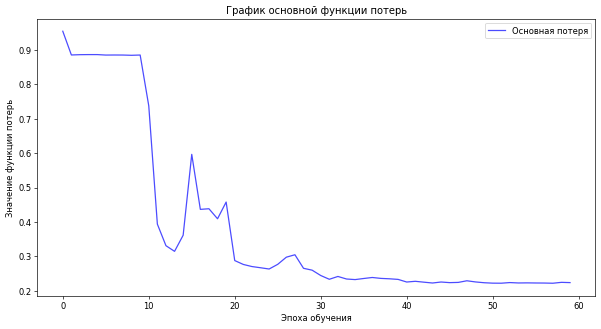

In [8]:
LV.show_training_loss()

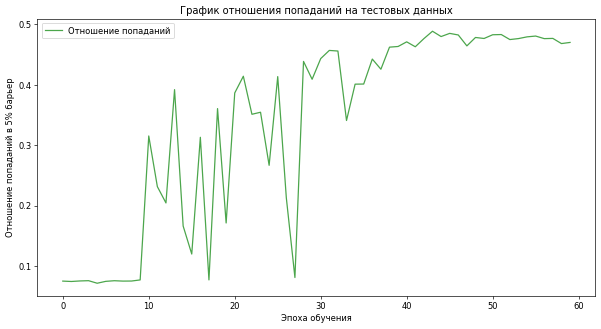

In [9]:
LV.show_test_tube()

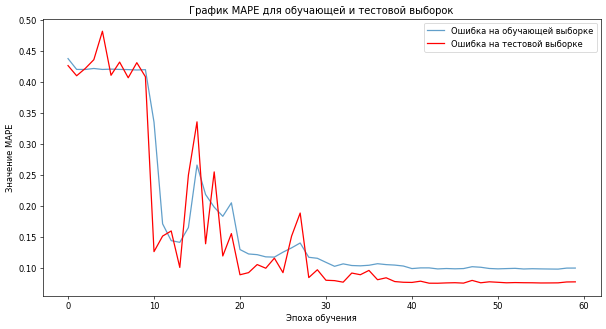

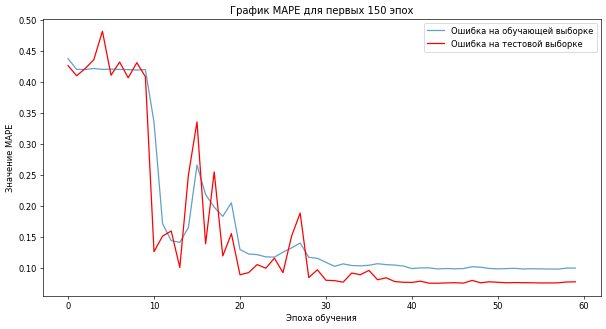

In [10]:
LV.show_mape()

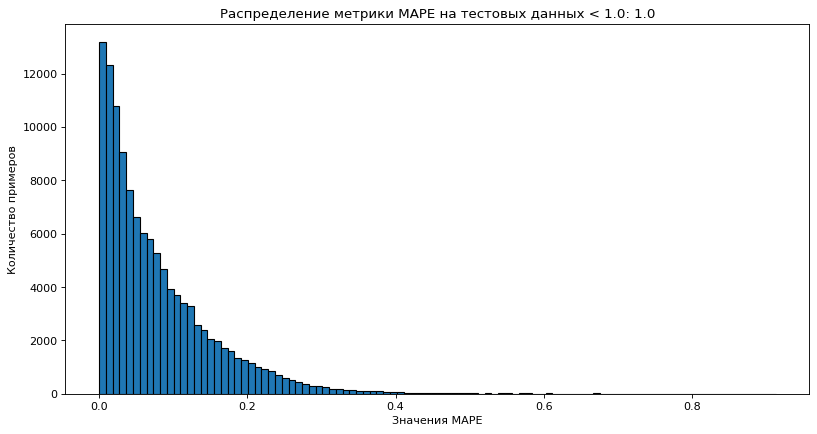

Процент значений MAPE < 1.0: 1.0


In [12]:
LV.histogram_mape(model,X_test,y_test,limit_percel = 100)

Количество записей: 5334


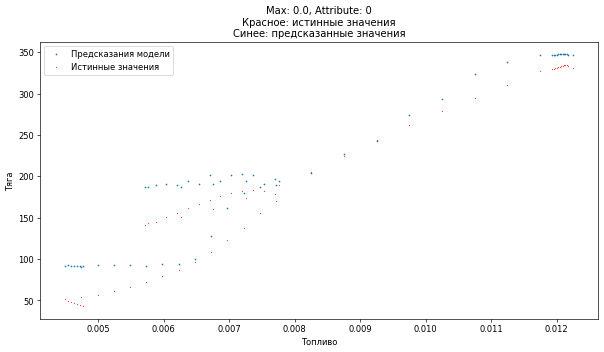

Количество записей: 5334


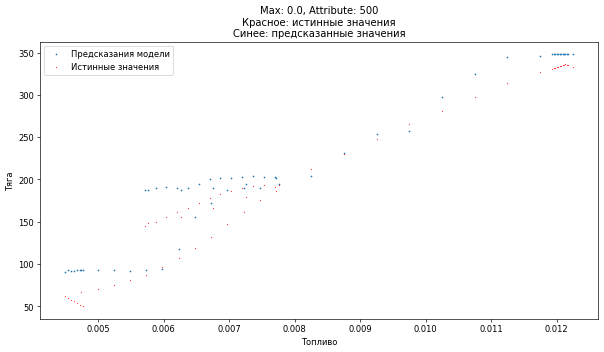

Количество записей: 5334


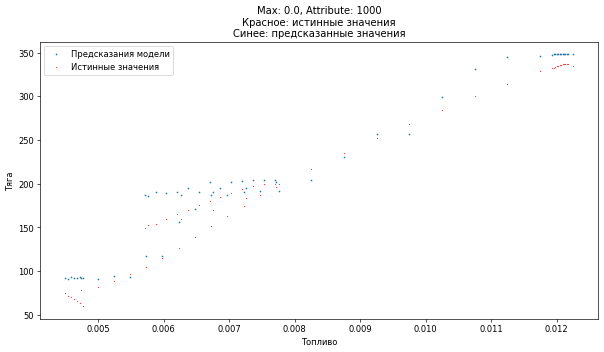

Количество записей: 5334


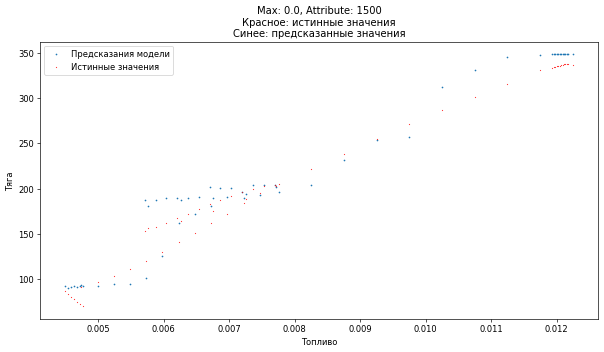

Количество записей: 5334


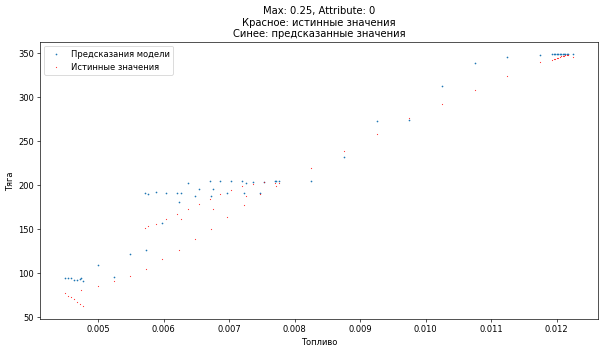

Количество записей: 5334


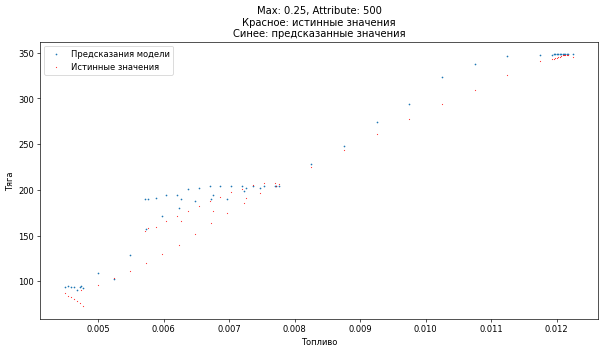

Количество записей: 5334


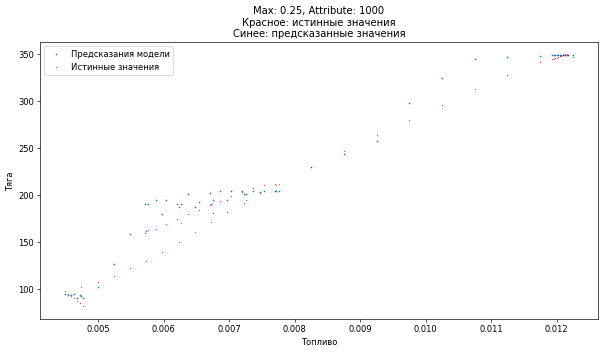

Количество записей: 5334


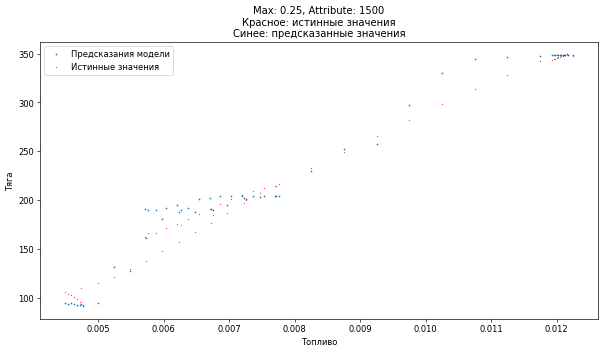

Количество записей: 5334


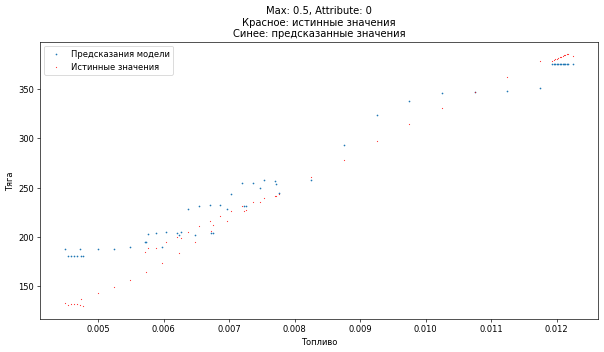

Количество записей: 5334


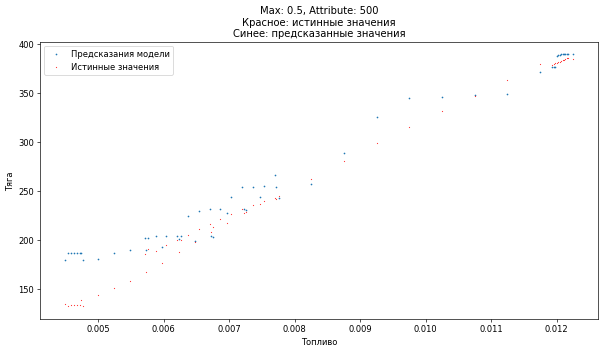

Количество записей: 5334


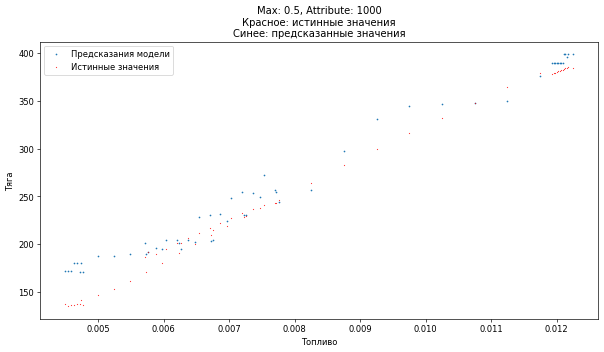

Количество записей: 5334


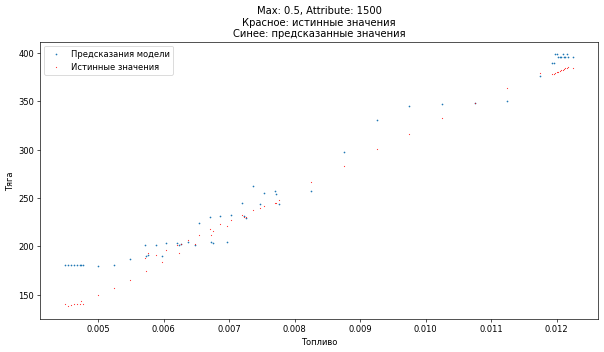

Количество записей: 5334


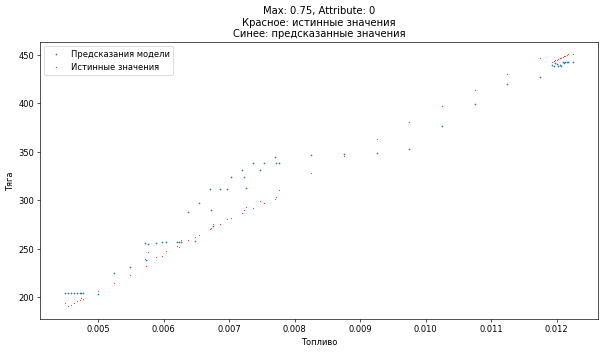

Количество записей: 5334


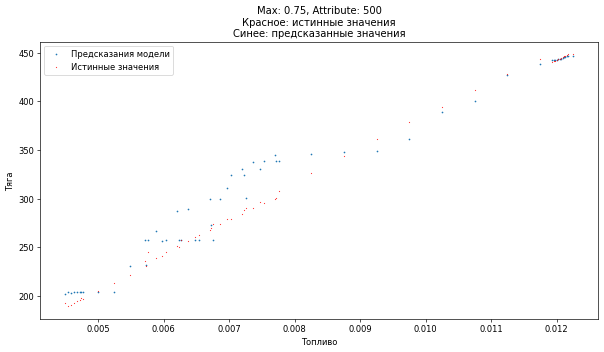

Количество записей: 5334


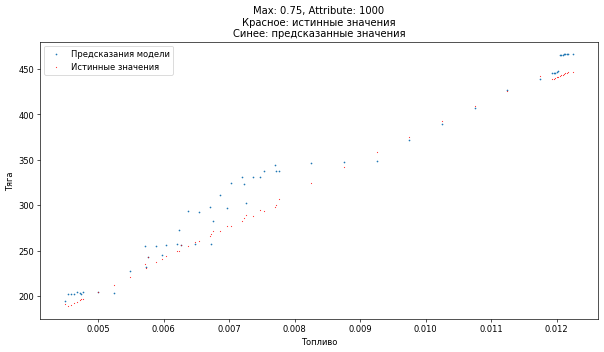

Количество записей: 5334


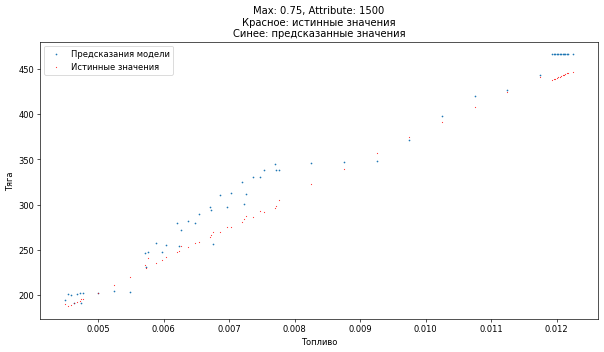

Количество записей: 5334


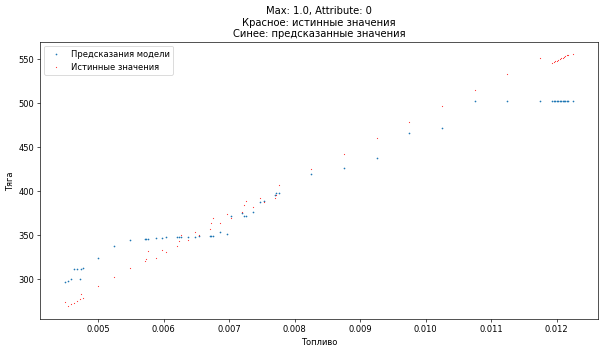

Количество записей: 5334


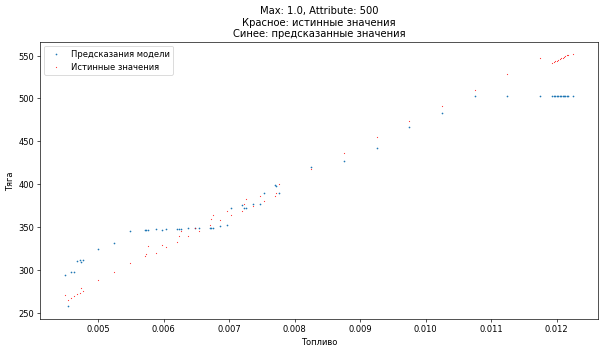

Количество записей: 5334


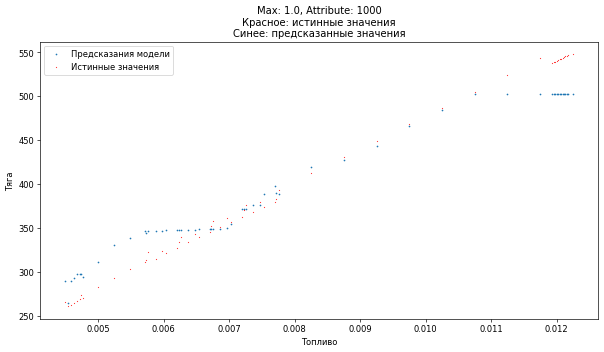

Количество записей: 5334


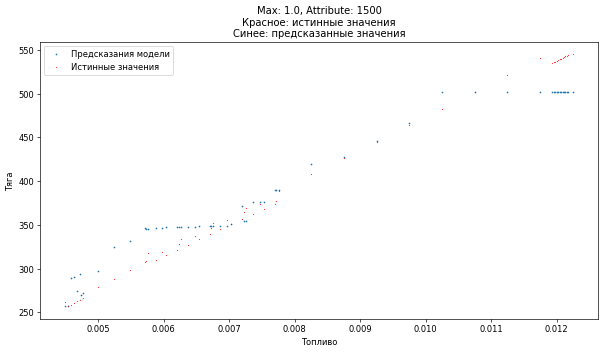

In [13]:
LV.show_predictions_rnn(model,df,(15,9,50,1),keras=False,device = device)

ЗДЕСЬ БУДЕТ ПРЕДСКАЗАНИЕ ЕСЛИ ЗАДАН ТОЛЬКО ПЕРВЫЙ МОМЕНТ ВРЕМЕНИ, ОСТАЛЬНЫЕ ТЯГИ САМОЛЕТА ПЕРЕДАЮТСЯ ИЗ ПРЕДСКАЗАНИЯ МОДЕЛИ

In [24]:
def req_step(model,df,input_x): 
    #print('input_x',input_x.shape)  
    predict = model(input_x).to(device)
    #print(predict.shape)
    prev = input_x[:,9:]
    #print(prev.shape)
    new_data = df
    #print(new_data.shape)

    cur = torch.cat((prev,predict,new_data),1)
    #print(cur.shape)
    return cur,predict

In [13]:
# можно выбрать attitute и махи
ma = 0.5
att = 500
new_df_for = df[(df[2] == att) & (df[5] == ma)][::50]

cur = torch.zeros((1, 10 * 9 - 1)).to(device)
#print(new_df_for.iloc[:9,1:])
# print(cur[:,:-8 ].shape)
# print(new_df_for.iloc[9][1:9].values.reshape(1,-1).shape)
# print(cur[:,-8: ].shape)
initt = torch.tensor(new_df_for.iloc[0,1:9].values, dtype=torch.float32).reshape(1,-1)
#print(new_inp.shape,initt.shape)
#cur[:,-8: ]= torch.tensor(new_df_for.iloc[0][1:9].values, dtype=torch.float32)
cur[:,:-8 ]= torch.tensor(new_df_for.iloc[:9,1:].values.reshape(1,-1), dtype=torch.float32)
cur[:,-8: ]= torch.tensor(new_df_for.iloc[9,1:9].values.reshape(1,-1), dtype=torch.float32)

data_predict = torch.empty(0).to(device)

In [14]:


for i in range(1, new_df_for.shape[0]):
    new_inp = torch.tensor(new_df_for.iloc[i][1:9].values, dtype=torch.float32).reshape(1,-1).to(device)
    cur, predict = req_step(model, new_inp, cur)
    data_predict = torch.cat((data_predict, predict))

IndexError: too many indices for tensor of dimension 2

In [90]:
data_predict.shape,new_df_for.shape

(torch.Size([106, 1]), (107, 10))

In [91]:
df_for_plot = new_df_for.copy()
placeholder = torch.tensor([[new_df_for.iloc[0, -1]]]) 

data_predict = data_predict.reshape(-1)

print(data_predict.shape) 


torch.Size([106])


In [92]:
x_rt = df_for_plot[1:][1]
y_rt = data_predict.to('cpu').detach().numpy()

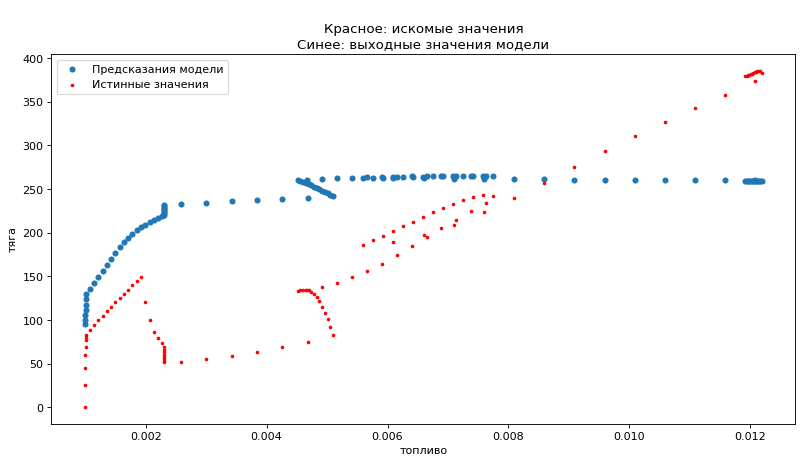

In [93]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x_rt, y_rt, s=20, label='Предсказания модели') 
plt.scatter(new_df_for[1], new_df_for[9], color='r', s=5, label='Истинные значения') 
plt.xlabel('топливо')  
plt.ylabel('тяга')  
plt.title(f'\nКрасное: искомые значения\nСинее: выходные значения модели')  
plt.legend()  
plt.show()